In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 1. Data Preparation & Analysis

## 1.1 Data Preparation

In [2]:
airbnb_df = pd.read_csv("AB_NYC_2019.csv")
airbnb_df.info()

airbnb_df['last_review'] = pd.to_datetime(airbnb_df['last_review'])
airbnb_df['days_since_last_review'] = (pd.Timestamp('2019-12-31') - airbnb_df['last_review']).dt.days
airbnb_df['reviews_per_month'] = airbnb_df['reviews_per_month'].replace(np.nan, 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [3]:
airbnb_df['last_review'] = pd.to_datetime(airbnb_df['last_review'])
airbnb_df['days_since_last_review'] = (pd.Timestamp('2019-12-31') - airbnb_df['last_review']).dt.days
airbnb_df['reviews_per_month'] = airbnb_df['reviews_per_month'].replace(np.nan, 0)
airbnb_df=airbnb_df.drop(['last_review','name','host_name'],axis=1)

In [4]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   host_id                         48895 non-null  int64  
 2   neighbourhood_group             48895 non-null  object 
 3   neighbourhood                   48895 non-null  object 
 4   latitude                        48895 non-null  float64
 5   longitude                       48895 non-null  float64
 6   room_type                       48895 non-null  object 
 7   price                           48895 non-null  int64  
 8   minimum_nights                  48895 non-null  int64  
 9   number_of_reviews               48895 non-null  int64  
 10  reviews_per_month               48895 non-null  float64
 11  calculated_host_listings_count  48895 non-null  int64  
 12  availability_365                

In [5]:
X = airbnb_df.drop(['price','id','host_id','neighbourhood'], axis=1)
y = airbnb_df['price']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

## 1.2 Exploratory Data Analysis

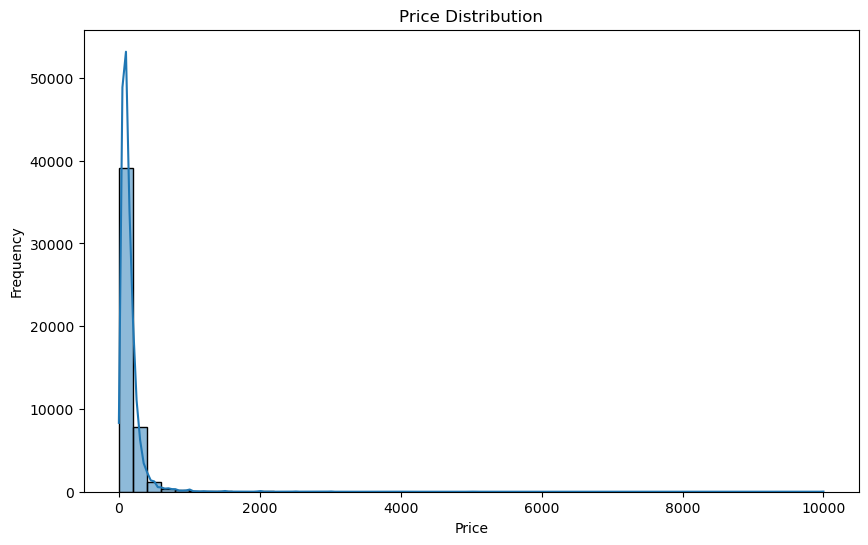

In [6]:
# Price distribution
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.savefig('price_distribution.png') 
plt.show()

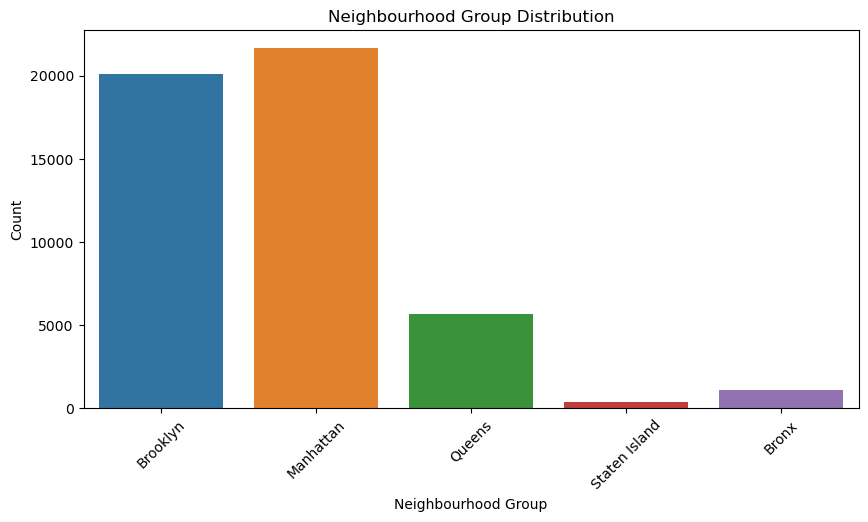

In [7]:
# Neighbourhood Group distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=X, x='neighbourhood_group')
plt.title('Neighbourhood Group Distribution')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)
plt.savefig('Neighbourhood Group Distribution.png') 
plt.show()

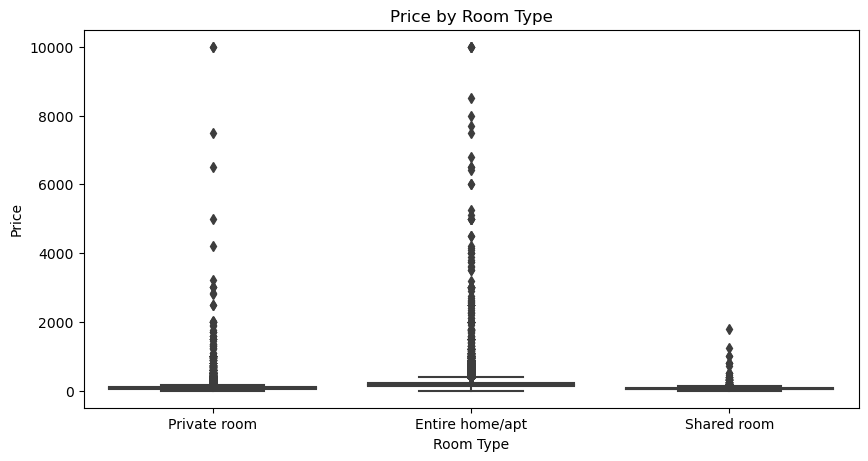

In [8]:
# Relationship between price and room type
plt.figure(figsize=(10, 6))
sns.boxplot(data=airbnb_df, x='room_type', y='price')
plt.title('Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.subplots_adjust(bottom=0.25)
plt.savefig('Price by Room Type.png') 
plt.show()

/var/folders/w3/05srrqwn71sbx094zd80gdlr0000gn/T/ipykernel_87201/2039911312.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(airbnb_df.corr(), annot=True, fmt=".2f")


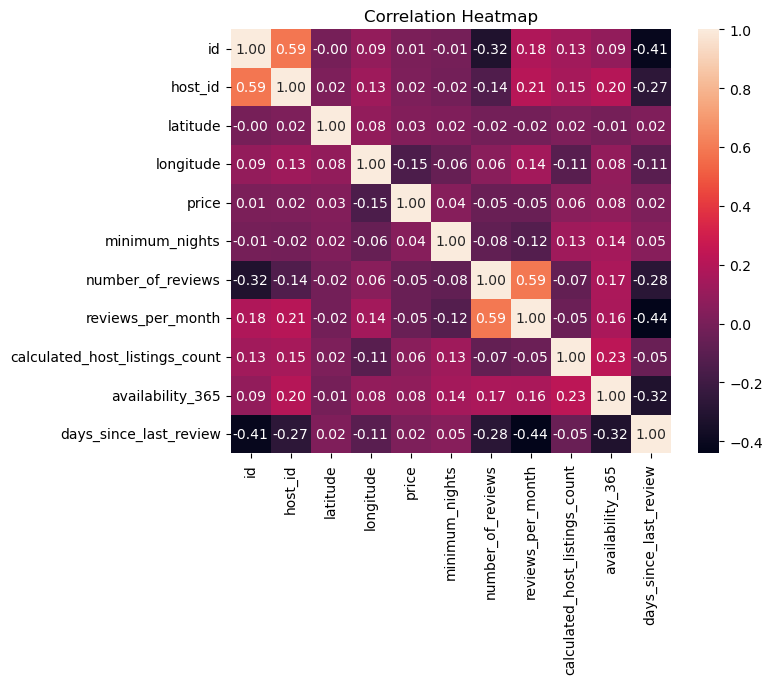

In [9]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(airbnb_df.corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.subplots_adjust(bottom=0.35, left=0.35)
plt.savefig('Correlation Heatmap.png') 
plt.show()

# 2. Data Preprocessing

## 2.1 Custom a imputer with max value + 1
Citation: https://stackoverflow.com/questions/44575114/building-a-custom-scikit-learn-imputer

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class MaxPlusOneImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.max_plus_one_ = np.nanmax(X) + 1
        return self

    def transform(self, X):
        return X.fillna(self.max_plus_one_)

    def get_feature_names_out(self, input_features=None):
        return input_features

##  2.2 Column Transformer

In [11]:
numeric_features = X_train.select_dtypes('int64','float64').columns
categorical_features = X_train.select_dtypes('object').columns

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('review', make_pipeline(MaxPlusOneImputer(), StandardScaler()), ['days_since_last_review']),
        ('numeric', StandardScaler(), numeric_features),
        ('categorical',OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough'
)

# 3. Building a Model

## 3.1 Dummy Regressor

In [13]:
from sklearn.dummy import DummyRegressor
dummy_pipeline = make_pipeline(
    preprocessor,
    DummyRegressor(strategy='median') 
)

In [14]:
dummy_pipeline.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('review',
                                                  Pipeline(steps=[('maxplusoneimputer',
                                                                   MaxPlusOneImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['days_since_last_review']),
                                                 ('numeric', StandardScaler(),
                                                  Index(['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['neighbourhood_group', 'room_type'], dtype='object'))])),
                ('dummyregressor', DummyRegressor(strategy='median'))])

In [15]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

scoring={
    "neg_mse": "neg_mean_squared_error",    
    "neg_rmse": "neg_root_mean_squared_error",    
    "mape_score": 'neg_mean_absolute_percentage_error',
    "r2": "r2",
}

In [16]:
dummy_scores_df = pd.DataFrame(
    cross_validate(
        dummy_pipeline,
        X_train,
        y_train, 
        scoring=scoring,
        cv=5, 
        return_train_score=True
    )
)

dummy_scores_df

,fit_time,score_time,test_neg_mse,train_neg_mse,test_neg_rmse,train_neg_rmse,test_mape_score,train_mape_score,test_r2,train_r2
0,0.042666,0.025245,-65716.597648,-59325.160456,-256.352487,-243.567569,-2.417576e+14,-7.555892e+13,-0.039018,-0.038412
1,0.034042,0.013764,-38990.924326,-66006.569520,-197.461197,-256.917437,-6.044714e+13,-1.208904e+14,-0.055799,-0.036037
2,0.044528,0.016033,-86606.262048,-53871.058096,-294.289419,-232.101396,-5.773609e-01,-1.385922e+14,-0.026381,-0.039003
3,0.038020,0.012662,-54582.210277,-61991.593903,-233.628359,-248.981112,-1.220457e+14,-1.067865e+14,-0.038622,-0.036547
4,0.032477,0.010512,-56837.418382,-61545.088582,-238.405995,-248.082826,-1.208943e+14,-1.057791e+14,-0.039997,-0.038182


## 3.2 Hyperparameter Tuning
### 3.2.1 Decision Tree Regressor

In [17]:
from sklearn.tree import DecisionTreeRegressor
decisiontree_pipeline = make_pipeline(
    preprocessor,
    DecisionTreeRegressor() 
)

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distributions = {
    "decisiontreeregressor__max_depth": randint(1, 50), 
    "decisiontreeregressor__min_samples_split": randint(2, 20),  
    "decisiontreeregressor__min_samples_leaf": randint(1, 20) 
}

decisiontree_random_search = RandomizedSearchCV(
    decisiontree_pipeline,
    param_distributions,
    cv=3, 
    return_train_score=True,
    n_jobs=-1,
    n_iter=200,
    scoring='r2',
    random_state=16
);
decisiontree_random_search.fit(X_train, y_train);

In [19]:
decisiontree_random_search.score(X_train, y_train)

0.15092947651899502

In [20]:
decisiontree_random_search.best_score_

0.09602272394285997

### 3.2.2 Ridge Regression

In [21]:
from sklearn.linear_model import Ridge
ridge_pipeline = make_pipeline(
    preprocessor,
    Ridge() 
)

In [22]:
param_grid = {
    "ridge__alpha": [0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0, 1000.0]
}

ridge_random_search = RandomizedSearchCV(
    ridge_pipeline,
    param_grid,
    cv=3, 
    return_train_score=True,
    n_jobs=-1,
    scoring='r2',
    random_state=16
)

ridge_random_search.fit(X_train, y_train)

/Users/agnes/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('review',
                                                                               Pipeline(steps=[('maxplusoneimputer',
                                                                                                MaxPlusOneImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['days_since_last_review']),
                                                                              ('numeric',
                                                                               StandardScaler(),
                                                                               Index(['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')),
                                                                              ('categorical',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               Index(['neighbourhood_group', 'room_type'], dtype='object'))])),
                                             ('ridge', Ridge())]),
                   n_jobs=-1,
                   param_distributions={'ridge__alpha': [0.01, 0.1, 1.0, 5.0,
                                                         10.0, 50.0, 100.0,
                                                         1000.0]},
                   random_state=16, return_train_score=True, scoring='r2')

In [23]:
ridge_random_search.score(X_train, y_train)

0.09963353351963244

In [24]:
ridge_random_search.best_score_

0.10255257879850255

### 3.2.3 Lasso Regression

In [25]:
from sklearn.linear_model import Lasso
lasso_pipeline = make_pipeline(
    preprocessor,
    Lasso() 
)

In [26]:
param_grid= {
    "lasso__alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 20.0, 50.0, 100.0]
}

lasso_random_search = RandomizedSearchCV(
    lasso_pipeline,
    param_grid,
    cv=3,
    return_train_score=True,
    n_jobs=-1,
    scoring='r2',
    random_state=16
)

lasso_random_search.fit(X_train, y_train)

/Users/agnes/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/agnes/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.717e+07, tolerance: 1.598e+05
  model = cd_fast.enet_coordinate_descent(
/Users/agnes/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.294e+07, tolerance: 1.325e+05
  model = cd_fast.enet_coordinate_descent(
/Users/agnes/anaconda3/lib/pytho

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('review',
                                                                               Pipeline(steps=[('maxplusoneimputer',
                                                                                                MaxPlusOneImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['days_since_last_review']),
                                                                              ('numeric',
                                                                               StandardScaler(),
                                                                               Index(['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')),
                                                                              ('categorical',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               Index(['neighbourhood_group', 'room_type'], dtype='object'))])),
                                             ('lasso', Lasso())]),
                   n_jobs=-1,
                   param_distributions={'lasso__alpha': [0.001, 0.01, 0.1, 1.0,
                                                         10.0, 20.0, 50.0,
                                                         100.0]},
                   random_state=16, return_train_score=True, scoring='r2')

In [27]:
lasso_random_search.score(X_train, y_train)

0.09963350059049125

In [28]:
lasso_random_search.best_score_

0.1025521768660878

### 3.2.4 XGBoost Regression

In [29]:
from xgboost import XGBRegressor

xgb_pipeline = make_pipeline(
    preprocessor,
    XGBRegressor()
)

param_distributions = {
    "xgbregressor__n_estimators": list(range(100, 1001, 100)),
    "xgbregressor__max_depth": list(range(1, 11, 1)), 
    "xgbregressor__learning_rate": [0.01, 0.05, 0.1, 0.2], 
    "xgbregressor__subsample":  [0.5, 0.75, 1] 
}

xgb_random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions,
    cv=3,
    return_train_score=True,
    n_jobs=-1,
    n_iter=50,
    scoring='r2',
    random_state=16
)

xgb_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('review',
                                                                               Pipeline(steps=[('maxplusoneimputer',
                                                                                                MaxPlusOneImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['days_since_last_review']),
                                                                              ('numeric',
                                                                               StandardScaler(),
                                                                               Index(['minimum_nights', 'number_of_reviews', 'calculated_host_...
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'xgbregressor__learning_rate': [0.01,
                                                                        0.05,
                                                                        0.1,
                                                                        0.2],
                                        'xgbregressor__max_depth': [1, 2, 3, 4,
                                                                    5, 6, 7, 8,
                                                                    9, 10],
                                        'xgbregressor__n_estimators': [100, 200,
                                                                       300, 400,
                                                                       500, 600,
                                                                       700, 800,
                                                                       900,
                                                                       1000],
                                        'xgbregressor__subsample': [0.5, 0.75,
                                                                    1]},
                   random_state=16, return_train_score=True, scoring='r2')

In [30]:
xgb_random_search.score(X_train, y_train)

0.3383884457415992

In [31]:
xgb_random_search.best_score_

0.12788400873579772

## 3.3 Model Selection and Results

In [32]:
model_scores = {
    'Decision Tree': decisiontree_random_search.best_score_,
    'Ridge': ridge_random_search.best_score_,
    'Lasso': lasso_random_search.best_score_,
    'XGBoost': xgb_random_search.best_score_
}

df_model_scores = pd.DataFrame(list(model_scores.items()), columns=['Model', 'Best Score'])

print(df_model_scores.sort_values(by='Best Score',ascending=False))

           Model  Best Score
3        XGBoost    0.127884
1          Ridge    0.102553
2          Lasso    0.102552
0  Decision Tree    0.096023


In [33]:
xgb_random_search.best_params_

{'xgbregressor__subsample': 0.5,
 'xgbregressor__n_estimators': 100,
 'xgbregressor__max_depth': 8,
 'xgbregressor__learning_rate': 0.01}

In [34]:
feature_importances=xgb_random_search.best_estimator_.named_steps['xgbregressor'].feature_importances_

In [35]:
feature_names = xgb_random_search.best_estimator_.named_steps['columntransformer'].get_feature_names_out()
feature_names = [name.split('__')[-1] for name in feature_names]
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                              Feature  Importance
10          room_type_Entire home/apt    0.553095
8          neighbourhood_group_Queens    0.090524
7       neighbourhood_group_Manhattan    0.060060
3      calculated_host_listings_count    0.041484
1                      minimum_nights    0.035976
0              days_since_last_review    0.032451
9   neighbourhood_group_Staten Island    0.029081
14                          longitude    0.026887
13                           latitude    0.026306
5           neighbourhood_group_Bronx    0.024872
4                    availability_365    0.022740
6        neighbourhood_group_Brooklyn    0.018995
2                   number_of_reviews    0.016718
11             room_type_Private room    0.012485
15                  reviews_per_month    0.008325
12              room_type_Shared room    0.000000


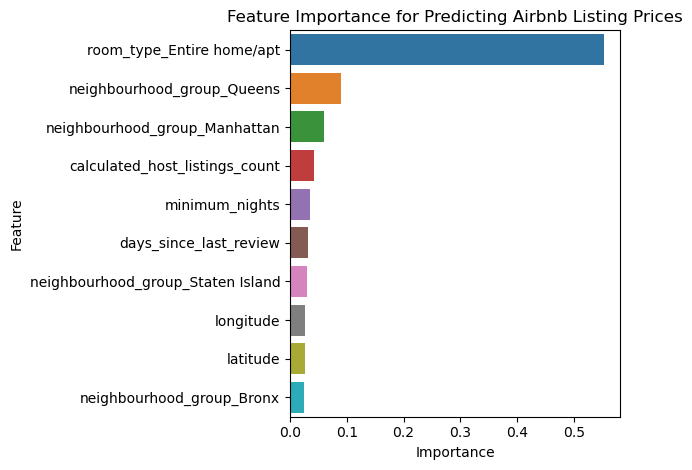

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10))
plt.title('Feature Importance for Predicting Airbnb Listing Prices')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

model_performance = []

models = [
    ('Dummy Regressor', dummy_pipeline),
    ('XG Boosting', xgb_random_search.best_estimator_)
]

for name, model in models:
    mse, mae, r2 = evaluate_model(model, X_train, X_test, y_train, y_test)
    model_performance.append({'Model': name, 'MSE': mse, 'MAE': mae, 'R^2': r2})

performance_df = pd.DataFrame(model_performance)
performance_df

,Model,MSE,MAE,R^2
0,Dummy Regressor,57336.233971,84.999284,-0.043625
1,XG Boosting,47068.246549,70.484394,0.143271
